# Experiments on the ForestNet Test Set
Now that we have embeddings, image urls, and geometries in Postgres, let's have a look at what we got

In [76]:
from pgvector.psycopg import register_vector
import psycopg
import matplotlib.pyplot as plt
from imageio import imread
import geopandas as gpd

In [2]:
# enable extension
conn = psycopg.connect(
    host="",
    user="",
    password="",
    dbname="",
    port=5432,
    autocommit=True,
)
register_vector(conn)

So I first need to double check that the images and lat/lon pairs actually line up with the arrays.

In [7]:
result = conn.execute("SELECT * FROM public.forestnet_testset LIMIT 1;").fetchall()[0]
result

(1,
 array([ 1.3636302 , -0.15653022,  0.77326965, -2.1039045 , -1.0084834 ,
         0.13051398, -1.8916262 ,  0.535868  , -0.6526873 , -0.7916367 ,
         2.5861933 , -1.6195015 , -0.221729  , -0.6092736 ,  1.0677372 ,
        -0.53999597,  0.86450505, -0.41284156,  0.83896106,  0.03157356,
         0.7992966 , -0.16646579, -0.95103514, -0.5415302 , -0.06415014,
         1.664354  ,  0.9859451 ,  0.0298393 ,  1.0810493 ,  0.84933156,
         0.13813753,  0.5566753 ], dtype=float32),
 1.4465431,
 100.79978,
 'https://ryans-website-thing-public.s3.us-west-2.amazonaws.com/ForestNetDataset/examples/1.446543071130837_100.79977801432716/images/visible/composite.png',
 '0101000020E6100000000000A02F335940000000600A25F73F')

/tmp/ipykernel_2579/2081807826.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(url)


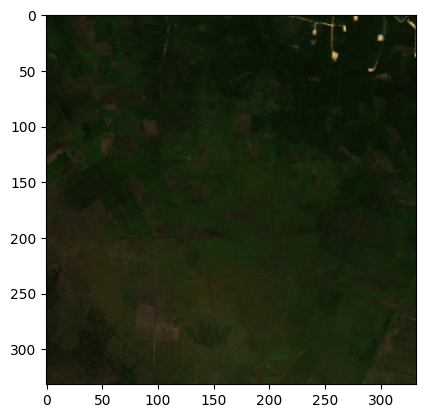

In [9]:
url = result[4]
img = imread(url)
plt.imshow(img)

The composite RGB image I have locally matches with the image supplied in the URL. Let's check another.

In [11]:
result = conn.execute("SELECT * FROM public.forestnet_testset ORDER BY id DESC LIMIT 1;").fetchall()[0]
result

(668,
 array([ 0.73347026, -0.76538366, -0.18129009, -2.0376625 , -0.8109051 ,
        -0.5780548 , -2.1743057 ,  0.39728928,  0.50823456, -0.7216924 ,
         2.154654  , -1.5943646 , -1.2992405 , -0.11807477,  1.0316614 ,
        -0.39249423, -0.1993296 ,  0.83866525,  0.34984893, -0.07516229,
         1.5102265 , -0.5552244 , -0.5851462 , -0.17548612, -0.9458171 ,
         1.3639733 ,  1.7918    ,  0.26973233,  1.1060241 ,  0.8312728 ,
        -0.35013884, -0.11285812], dtype=float32),
 -0.21467265,
 103.51058,
 'https://ryans-website-thing-public.s3.us-west-2.amazonaws.com/ForestNetDataset/examples/-0.2146726494964884_103.51057948511792/images/visible/composite.png',
 '0101000020E610000000000060ADE05940000000C0647ACBBF')

/tmp/ipykernel_2579/2081807826.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(url)


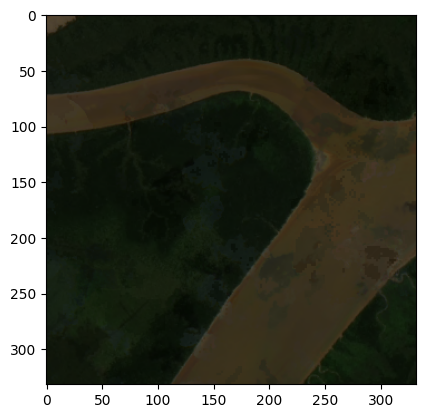

In [12]:
url = result[4]
img = imread(url)
plt.imshow(img)

So everything appears to be okay, though this test was very imperfect. The config file used for inference specified that data was not to be shuffled. Since the lat/lons and img urls were not passed to the Data Loader, I really don't actually know if the embeddings match.

But so far so good. I wonder what the closest image to that of the one above looks like.

In [15]:
embedding = result[1]
# L2 distance is <-> 
nearest_neighbor = conn.execute('SELECT * FROM public.forestnet_testset ORDER BY embedding <-> %s LIMIT 2', (embedding,)).fetchall()[1]
nearest_neighbor

(469,
 array([ 0.8579791 , -0.795441  , -0.21943384, -1.9128352 , -1.0248562 ,
        -0.73440176, -2.0622594 ,  0.44319046,  0.47046497, -0.7796708 ,
         1.8792348 , -1.5305725 , -1.1873128 , -0.15245438,  1.1241088 ,
        -0.28593487, -0.3560828 ,  0.7457126 ,  0.3865503 ,  0.09548783,
         1.5117742 , -0.43048158, -0.7856875 , -0.12753378, -1.1157658 ,
         1.1775644 ,  1.9895545 ,  0.3989378 ,  1.1645844 ,  0.8248057 ,
        -0.30747372, -0.13996278], dtype=float32),
 3.8593767,
 117.684715,
 'https://ryans-website-thing-public.s3.us-west-2.amazonaws.com/ForestNetDataset/examples/3.859376785602465_117.68471906082053/images/visible/composite.png',
 '0101000020E610000000000060D26B5D40000000E000E00E40')

/tmp/ipykernel_2579/2875400048.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(url)


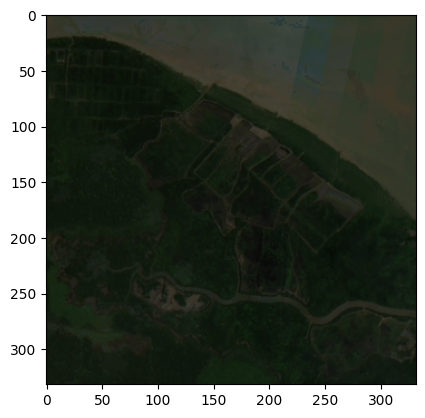

In [16]:
url = nearest_neighbor[4]
img = imread(url)
plt.imshow(img)

Well that's cool. Both look like rivers. I think the similarity has to do with the abundance of water. RGB sux, but it's what we got.

What are the distances between these guys anyway?

In [54]:
# Yeah these queries are weird 
# L2 Distance
conn.execute('SELECT embedding <-> %s FROM forestnet_testset WHERE id = 469', (embedding,)).fetchall()[0][0]

0.695604241704923

In [55]:
# negative inner product
conn.execute('SELECT embedding <#> %s FROM forestnet_testset WHERE id = 469', (embedding,)).fetchall()[0][0]

-33.47478485107422

In [56]:
# cosine distance
conn.execute('SELECT embedding <=> %s FROM forestnet_testset WHERE id = 469', (embedding,)).fetchall()[0][0]

0.00714257979409505

In [57]:
# L1 distance
conn.execute('SELECT embedding <-> %s FROM forestnet_testset WHERE id = 469', (embedding,)).fetchall()[0][0]

0.695604241704923

In [62]:
# Cartesian distance (kilometers)
conn.execute("""
               SELECT ST_Distance(
                  ST_Transform(%s::geometry, 23830),
                  ST_Transform(%s::geometry, 23830)
               )
             """,(result[5], nearest_neighbor[5])).fetchall()[0][0] / 1000

1711.9477822844894

Well what's all this without a map, huh?

In [78]:
query = "SELECT id, geom FROM public.forestnet_testset WHERE id = 668 OR id = 443 ORDER BY id DESC"

In [79]:
gdf = gpd.read_postgis(query, conn)
gdf.explore()


Cool beans. How about another... and maybe a few more neighbors?

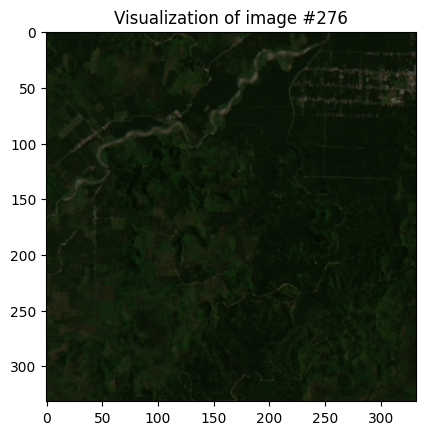

In [107]:
result = conn.execute("SELECT * FROM public.forestnet_testset ORDER BY RANDOM() LIMIT 1;").fetchall()[0]
url = result[4]
img = imread(url)
plt.title(f"Visualization of image #{result[0]}")
plt.imshow(img)

In [100]:
embedding = result[1]
# How about 3 neighbors?
nearest_neighbors = conn.execute('SELECT * FROM public.forestnet_testset ORDER BY embedding <-> %s LIMIT 4', (embedding,)).fetchall()[1:]

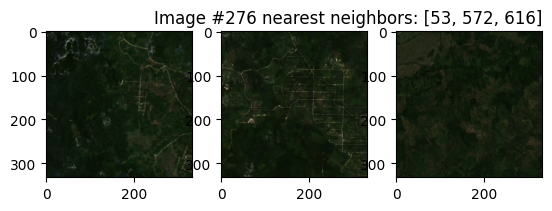

In [112]:
image_datas = []
ids = []
for neighbor in nearest_neighbors:
    image_datas.append(imread(neighbor[4]))
    ids.append(neighbor[0])

f, axarr = plt.subplots(1, 3)  # Create a 1x3 grid of subplots
axarr[0].imshow(image_datas[0])
axarr[1].imshow(image_datas[1])
axarr[2].imshow(image_datas[2])
plt.title(f"Image #{result[0]} nearest neighbors: {ids}", loc="right")
plt.show()

In [113]:
query_ids = [result[0]] + ids
query = f"""
            SELECT id, geom 
            FROM public.forestnet_testset 
            WHERE id = {query_ids[0]} OR id = {query_ids[1]} OR id = {query_ids[2]} OR  id = {query_ids[3]}  
        """
gdf = gpd.read_postgis(query, conn)
gdf.explore()

Not sure there is a strong correlation between vector distance and geographic distance.  